In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from scipy.stats import poisson, nbinom
import geopandas as gpd
import folium
from IPython.display import display

# Set style
plt.style.use('ggplot')
%matplotlib inline

# View max columns
pd.set_option('display.max_columns', None)

# Reading in the Data

In [ ]:
# Read in the data
data = pd.read_csv('final_data.csv')

# Replace the PWS_TYPE categories
data['PWS_TYPE'] = data['PWS_TYPE'].replace({'NTNCS': 'NTNCWS', 'TNCS': 'TNCWS'})

# View the data
data.head()

,PWS_ID,OWNER_TYPE,YEAR_FULL,COUNTY,PWS_TYPE,POPULATION,SERV_CON,SOURCE,WHOLESALER,FACILITIES,VIOLATIONS,SITE_VISITS,MED_INCOME,POV_RATE,AVG_PRECIP,AVG_TEMP,PERCENT_REP,PERCENT_DEM,PERCENT_OTH,YEAR_FAC,YEAR
0,CA0103040,Private,2013,Alameda,CWS,100,19,GW,No,16,2,4,72112,0.125,5.08,59.5,0.1405,0.5643,0.2952,2013,1
1,CA0103040,Private,2014,Alameda,CWS,100,19,GW,No,8,2,5,73775,0.129,19.88,62.0,0.1372,0.5606,0.3022,2014,2
2,CA0103040,Private,2015,Alameda,CWS,100,19,GW,No,8,2,5,75619,0.125,10.39,61.1,0.1336,0.5523,0.3141,2015,3
3,CA0103040,Private,2016,Alameda,CWS,100,19,GW,No,8,2,5,79831,0.120,22.55,60.4,0.1297,0.5626,0.3077,2016,4
4,CA0103040,Private,2017,Alameda,CWS,50,19,GW,No,8,54,5,85743,0.113,24.97,60.5,0.1207,0.5760,0.3033,2017,5


In [ ]:
# Desired orders for categorical variables
owner_type_order = ['Public', 'Private', 'PPP']
pws_type_order = ['CWS', 'NTNCWS', 'TNCWS']
primary_source_order = ['GW', 'SW', 'UNK']
is_wholesaler_order = ['No', 'Yes']

In [ ]:
# Convert categorical variables to appropriate data types
data['OWNER_TYPE'] = pd.Categorical(data['OWNER_TYPE'], categories=owner_type_order, ordered=False)
data['PWS_TYPE'] = pd.Categorical(data['PWS_TYPE'], categories=pws_type_order, ordered=False)
data['SOURCE'] = pd.Categorical(data['SOURCE'], categories=primary_source_order, ordered=False)
data['WHOLESALER'] = pd.Categorical(data['WHOLESALER'], categories=is_wholesaler_order, ordered=False)
data['YEAR_FAC'] = data['YEAR_FAC'].astype('category')

# Descriptive Analysis

In [ ]:
# Overall descriptive statistics
data.describe().T.round(2).drop([
    'YEAR_FULL',
    'YEAR'
])

,count,mean,std,min,25%,50%,75%,max
POPULATION,66770.0,6363.81,65133.90,0.00,50.00,125.00,440.00,4085000.00
SERV_CON,66770.0,1455.63,12534.45,0.00,2.00,16.00,80.00,727143.00
FACILITIES,66770.0,8.95,23.31,0.00,3.00,4.00,7.00,1784.00
VIOLATIONS,66770.0,9.79,13.11,0.00,2.00,5.00,12.00,278.00
SITE_VISITS,66770.0,12.15,14.06,0.00,5.00,8.00,14.00,287.00
MED_INCOME,66770.0,64089.07,17748.36,34974.00,51457.00,60704.00,73518.00,153792.00
POV_RATE,66770.0,0.16,0.05,0.05,0.12,0.15,0.19,0.28
AVG_PRECIP,66770.0,21.13,16.09,2.06,9.56,16.12,28.74,97.59
AVG_TEMP,66770.0,60.09,5.08,43.50,57.30,60.20,63.40,76.50
PERCENT_REP,66770.0,0.32,0.09,0.06,0.24,0.33,0.40,0.55


In [ ]:
# View all rows
pd.set_option('display.max_rows', None)

# Descriptive statistics table by OWNER_TYPE
data.groupby('OWNER_TYPE').describe().T.round(2).drop([
    'YEAR_FULL',
    'YEAR'
])

OWNER_TYPE             Public     Private        PPP
POPULATION  count    22425.00    43493.00     852.00
            mean     15530.43     1757.86     219.37
            std     108451.08    19583.73     462.55
            min          0.00        0.00      25.00
            25%        100.00       45.00      40.00
            50%        370.00      100.00     100.00
            75%       3072.00      228.00     200.00
            max    4085000.00  1007514.00    2800.00
SERV_CON    count    22425.00    43493.00     852.00
            mean      3518.63      419.97      25.61
            std      20580.49     4417.12      54.80
            min          0.00        0.00       1.00
            25%          3.00        2.00       1.00
            50%         24.00       15.00       5.00
            75%        768.00       50.00      21.25
            max     727143.00   225800.00     501.00
FACILITIES  count    22425.00    43493.00     852.00
            mean        13.42        6.62       9.83
            std         34.60       14.15       7.30
            min          0.00        0.00       0.00
            25%          3.00        3.00       3.00
            50%          5.00        4.00      10.00
            75%         11.00        6.00      15.00
            max       1784.00      786.00      51.00
VIOLATIONS  count    22425.00    43493.00     852.00
            mean         8.28       10.57      10.09
            std         13.33       12.93      13.14
            min          0.00        0.00       0.00
            25%          1.00        2.00       2.00
            50%          4.00        6.00       6.00
            75%          9.00       14.00      13.00
            max        278.00      145.00      96.00
SITE_VISITS count    22425.00    43493.00     852.00
            mean        13.19       11.70       7.63
            std         15.91       13.09       5.15
            min          0.00        0.00       0.00
            25%          6.00        5.00       5.00
            50%          9.00        8.00       6.00
            75%         16.00       13.00       9.00
            max        287.00      202.00      51.00
MED_INCOME  count    22425.00    43493.00     852.00
            mean     63279.12    64675.98   55446.98
            std      18340.56    17447.78   13550.22
            min      34974.00    34974.00   41924.00
            25%      50125.00    52874.00   45742.00
            50%      58861.00    61276.00   51261.00
            75%      71358.00    73814.00   57585.00
            max     153792.00   153792.00  124055.00
POV_RATE    count    22425.00    43493.00     852.00
            mean         0.16        0.16       0.20
            std          0.05        0.05       0.05
            min          0.05        0.05       0.07
            25%          0.12        0.12       0.18
            50%          0.16        0.15       0.21
            75%          0.20        0.19       0.23
            max          0.28        0.28       0.28
AVG_PRECIP  count    22425.00    43493.00     852.00
            mean        21.26       21.05      21.92
            std         16.59       15.90      12.31
            min          2.06        2.06       3.12
            25%          9.28        9.56      14.42
            50%         16.04       16.14      20.72
            75%         29.23       28.67      26.34
            max         97.59       97.59      75.84
AVG_TEMP    count    22425.00    43493.00     852.00
            mean        59.77       60.28      58.70
            std          5.61        4.81       3.26
            min         43.50       43.50      47.90
            25%         56.40       57.60      56.70
            50%         60.00       60.40      57.90
            75%         63.40       63.40      60.15
            max         76.50       76.50      69.00
PERCENT_REP count    22425.00    43493.00     852.00
            mean         0.33        0.32       0.38
            std          

In [ ]:
# Value counts of OWNER_TYPE
data['OWNER_TYPE'].value_counts()

OWNER_TYPE
Private    43493
Public     22425
PPP          852
Name: count, dtype: int64

In [ ]:
# Value counts of OWNER_TYPE (proportions)
data['OWNER_TYPE'].value_counts(normalize=True)

OWNER_TYPE
Private    0.651385
Public     0.335854
PPP        0.012760
Name: proportion, dtype: float64

In [ ]:
# Function to get value counts for each categorical column
def get_value_counts(df, categorical_columns):
    value_counts_dict = {}
    for col in categorical_columns:
        value_counts = df[col].value_counts()
        value_counts_dict[col] = value_counts
    return value_counts_dict

In [ ]:
# Define the categorical columns
categorical_columns = ['PWS_TYPE', 'SOURCE', 'WHOLESALER', 'COUNTY']

# Get value counts for categorical columns
value_counts_dict = get_value_counts(data, categorical_columns)

# Display the results
for col, counts in value_counts_dict.items():
    print(f"Value counts for {col}:\n", counts, "\n")

Value counts for PWS_TYPE:
 PWS_TYPE
CWS       28113
TNCWS     25874
NTNCWS    12783
Name: count, dtype: int64 

Value counts for SOURCE:
 SOURCE
GW     55668
SW     10048
UNK     1054
Name: count, dtype: int64 

Value counts for WHOLESALER:
 WHOLESALER
No     65872
Yes      898
Name: count, dtype: int64 

Value counts for COUNTY:
 COUNTY
Sonoma             3930
Kern               3130
San Bernardino     3120
Fresno             3060
Monterey           2990
San Joaquin        2970
Tulare             2860
Los Angeles        2800
Riverside          1930
Stanislaus         1880
Madera             1870
San Diego          1870
Shasta             1670
Sacramento         1610
Napa               1440
San Luis Obispo    1340
Santa Barbara      1280
El Dorado          1210
Tuolumne           1180
Placer             1160
Santa Clara        1140
Mendocino          1110
Inyo               1100
Tehama             1040
Plumas             1040
Ventura             970
Santa Cruz          890
Contra Cost

In [ ]:
# Function to get value counts for each categorical column grouped by OWNER_TYPE
def get_value_counts_grouped(df, categorical_columns, groupby_col):
    value_counts_dict = {}
    for col in categorical_columns:
        value_counts = df.groupby(groupby_col)[col].value_counts().unstack().fillna(0)
        value_counts_dict[col] = value_counts
    return value_counts_dict

In [ ]:
# Get value counts for categorical columns
value_counts_dict = get_value_counts_grouped(data, categorical_columns, 'OWNER_TYPE')

# Display the results
for col, counts in value_counts_dict.items():
    print(f"Value counts for {col}:\n", counts, "\n")

Value counts for PWS_TYPE:
 PWS_TYPE      CWS  NTNCWS  TNCWS
OWNER_TYPE                      
Public      10830    4465   7130
Private     17103    8143  18247
PPP           180     175    497 

Value counts for SOURCE:
 SOURCE         GW    SW  UNK
OWNER_TYPE                  
Public      16076  6064  285
Private     38783  3957  753
PPP           809    27   16 

Value counts for WHOLESALER:
 WHOLESALER     No  Yes
OWNER_TYPE            
Public      21721  704
Private     43299  194
PPP           852    0 

Value counts for COUNTY:
 COUNTY      Alameda  Alpine  Amador  Butte  Calaveras  Colusa  Contra Costa  \
OWNER_TYPE                                                                    
Public          150     154     197    280        175      90           260   
Private          43     256     399    550        295     160           593   
PPP              17       0      14      0          0       0             7   

COUNTY      Del Norte  El Dorado  Fresno  Glenn  Humboldt  Impe

In [ ]:
# Descriptive statistics for categorical variables by OWNER_TYPE
data[categorical_columns + ['OWNER_TYPE']].groupby('OWNER_TYPE').describe().T

OWNER_TYPE              Public Private     PPP
PWS_TYPE   count         22425   43493     852
           unique            3       3       3
           top             CWS   TNCWS   TNCWS
           freq          10830   18247     497
SOURCE     count         22425   43493     852
           unique            3       3       3
           top              GW      GW      GW
           freq          16076   38783     809
WHOLESALER count         22425   43493     852
           unique            2       2       1
           top              No      No      No
           freq          21721   43299     852
COUNTY     count         22425   43493     852
           unique           58      57      24
           top     Los Angeles  Sonoma  Madera
           freq           1307    3234     437

In [ ]:
# Pivot table of mean violations by OWNER_TYPE and YEAR
mean_violations = data.pivot_table(index='OWNER_TYPE', columns='YEAR_FAC', values='VIOLATIONS', aggfunc='mean')
print("Mean Violations by Owner Type and Year:")
mean_violations

Mean Violations by Owner Type and Year:


YEAR_FAC,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
OWNER_TYPE,,,,,,,,,,
Public,6.964026,7.925474,7.310453,7.752444,8.062333,8.491103,8.719181,8.952759,9.094923,9.422517
Private,9.168101,11.204773,9.310817,9.846944,10.194406,10.578923,10.908858,11.200409,11.448581,11.774347
PPP,9.179104,10.857143,9.321429,10.099291,10.170213,10.464286,10.757143,8.500000,7.571429,8.285714


In [ ]:
# Pivot table of standard deviation of violations by OWNER_TYPE and YEAR
std_violations = data.pivot_table(index='OWNER_TYPE', columns='YEAR_FAC', values='VIOLATIONS', aggfunc='std')
print("Standard Deviation of Violations by Owner Type and Year:")
std_violations

Standard Deviation of Violations by Owner Type and Year:


YEAR_FAC,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
OWNER_TYPE,,,,,,,,,,
Public,10.436928,11.544619,11.357168,11.882055,12.277259,14.119236,14.538091,14.859946,15.114998,15.668984
Private,10.541720,12.739156,11.126651,11.856568,12.349782,13.061150,13.594907,13.948861,14.350039,14.704922
PPP,12.470481,14.771220,11.903852,13.225681,13.164323,13.668959,14.069136,7.314369,7.114706,6.701102


In [ ]:
# Pivot table of median violations by OWNER_TYPE and YEAR
median_violations = data.pivot_table(index='OWNER_TYPE', columns='YEAR_FAC', values='VIOLATIONS', aggfunc='median')
print("Median Violations by Owner Type and Year:")
median_violations

Median Violations by Owner Type and Year:


YEAR_FAC,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
OWNER_TYPE,,,,,,,,,,
Public,4,4,4,4,4,4,4,4,4,5
Private,6,7,5,6,6,6,6,7,7,7
PPP,5,6,6,6,6,6,6,6,4,7


In [ ]:
# Pivot table of IQR of violations by OWNER_TYPE and YEAR
violation_iqr = data.pivot_table(index='OWNER_TYPE', columns='YEAR_FAC', values='VIOLATIONS', aggfunc=lambda x: x.quantile(0.75) - x.quantile(0.25))
print("Interquartile Range (IQR) of Violations by Owner Type and Year:")
violation_iqr

Interquartile Range (IQR) of Violations by Owner Type and Year:


YEAR_FAC,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
OWNER_TYPE,,,,,,,,,,
Public,7.0,9.0,7.0,8.0,8.0,8.0,9.0,8.00,8.0,8.0
Private,10.0,12.0,10.0,11.0,11.0,11.0,11.0,11.00,11.0,12.0
PPP,9.5,10.0,9.0,11.0,11.0,11.0,11.0,12.25,10.5,9.5


In [ ]:
# Pivot table of minimum violations by OWNER_TYPE and YEAR
min_violations = data.pivot_table(index='OWNER_TYPE', columns='YEAR_FAC', values='VIOLATIONS', aggfunc='min')
print("Minimum Violations by Owner Type and Year:")
min_violations

Minimum Violations by Owner Type and Year:


YEAR_FAC,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
OWNER_TYPE,,,,,,,,,,
Public,0,0,0,0,0,0,0,0,0,0
Private,0,0,0,0,0,0,0,0,0,0
PPP,0,0,0,0,0,0,0,2,2,2


In [ ]:
# Pivot table of maximum violations by OWNER_TYPE and YEAR
max_violations = data.pivot_table(index='OWNER_TYPE', columns='YEAR_FAC', values='VIOLATIONS', aggfunc='max')
print("Maximum Violations by Owner Type and Year:")
max_violations

Maximum Violations by Owner Type and Year:


YEAR_FAC,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
OWNER_TYPE,,,,,,,,,,
Public,152,149,149,149,149,276,276,276,277,278
Private,101,130,99,113,117,121,125,131,145,145
PPP,60,72,72,95,96,96,96,18,18,18


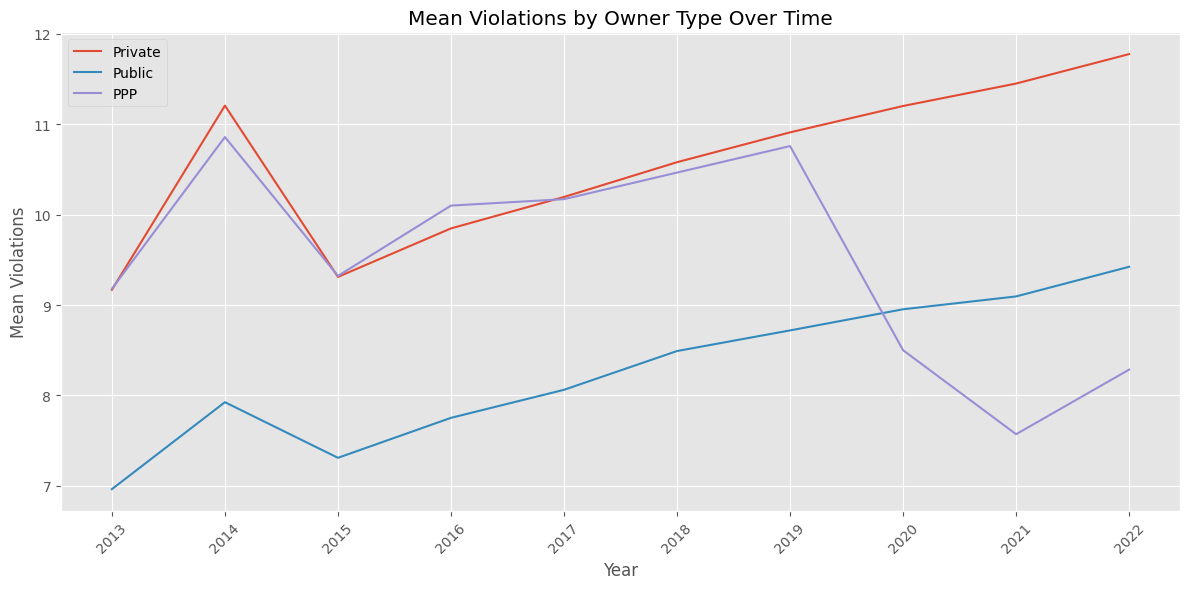

In [ ]:
# Time series plot of mean violations by OWNER_TYPE over all years
fig, ax = plt.subplots(figsize=(12, 6))
for owner_type in data['OWNER_TYPE'].unique():
    violations_data = data[data['OWNER_TYPE'] == owner_type].groupby('YEAR_FAC')['VIOLATIONS'].mean()
    ax.plot(violations_data.index, violations_data.values, label=owner_type)
ax.set_xlabel('Year')
ax.set_ylabel('Mean Violations')
ax.set_title('Mean Violations by Owner Type Over Time')
ax.set_xticks(data['YEAR_FAC'].unique())
ax.set_xticklabels(data['YEAR_FAC'].unique(), rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

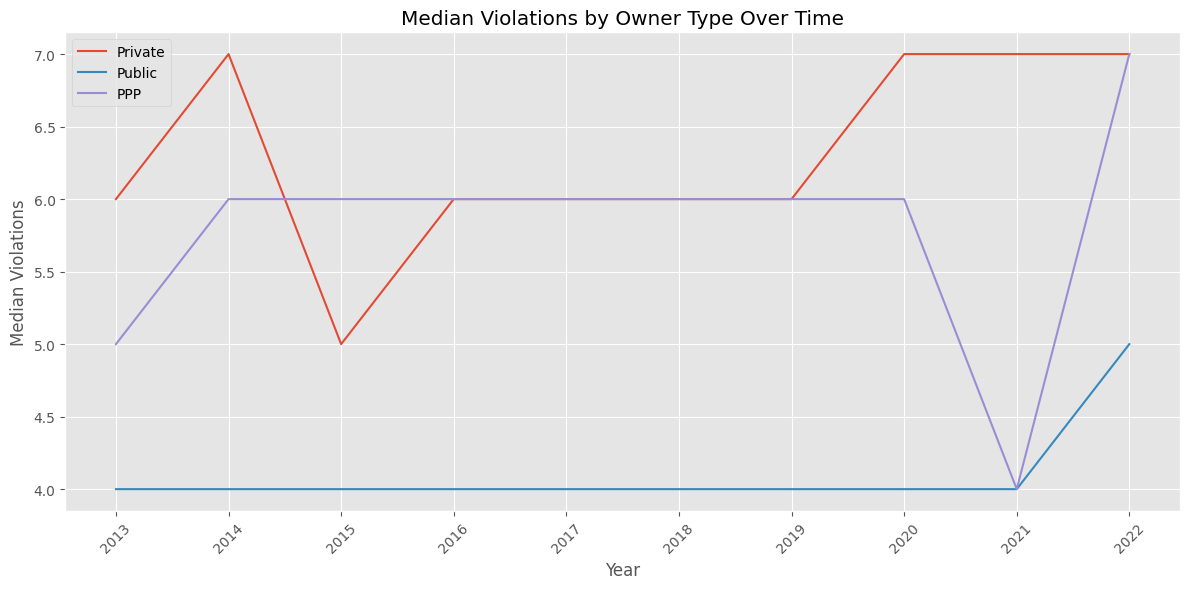

In [ ]:
# Time series plot of median violations by OWNER_TYPE over all years
fig, ax = plt.subplots(figsize=(12, 6))
for owner_type in data['OWNER_TYPE'].unique():
    violations_data = data[data['OWNER_TYPE'] == owner_type].groupby('YEAR_FAC')['VIOLATIONS'].median()
    ax.plot(violations_data.index, violations_data.values, label=owner_type)
ax.set_xlabel('Year')
ax.set_ylabel('Median Violations')
ax.set_title('Median Violations by Owner Type Over Time')
ax.set_xticks(data['YEAR_FAC'].unique())
ax.set_xticklabels(data['YEAR_FAC'].unique(), rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

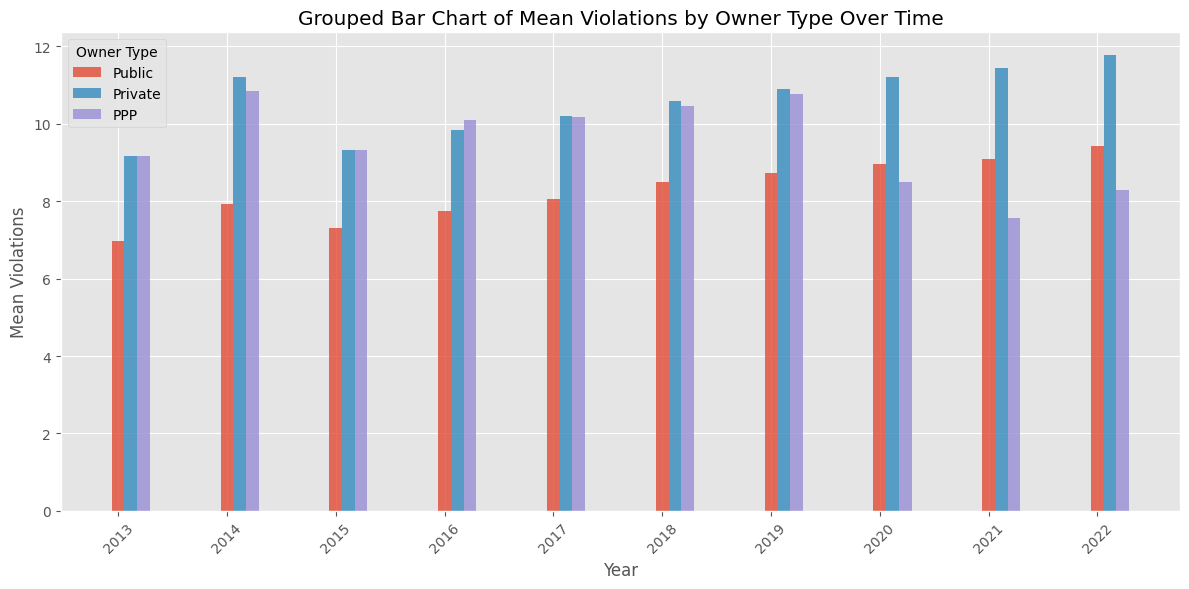

In [ ]:
# Pivot table of mean violations by YEAR and OWNER_TYPE
mean_violations_by_year = data.pivot_table(index='YEAR_FAC', columns='OWNER_TYPE', values='VIOLATIONS', aggfunc='mean')

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
opacity = 0.8

years = mean_violations_by_year.index.astype(int)
num_years = len(years)
num_owner_types = len(mean_violations_by_year.columns)

for i, owner_type in enumerate(mean_violations_by_year.columns):
    ax.bar(years + i * bar_width / num_owner_types, mean_violations_by_year[owner_type],
           width=bar_width / num_owner_types, alpha=opacity, label=owner_type)

ax.set_xlabel('Year')
ax.set_ylabel('Mean Violations')
ax.set_title('Grouped Bar Chart of Mean Violations by Owner Type Over Time')
ax.set_xticks(years)
ax.set_xticklabels(years, rotation=45)
ax.legend(title='Owner Type')

plt.tight_layout()
plt.show()

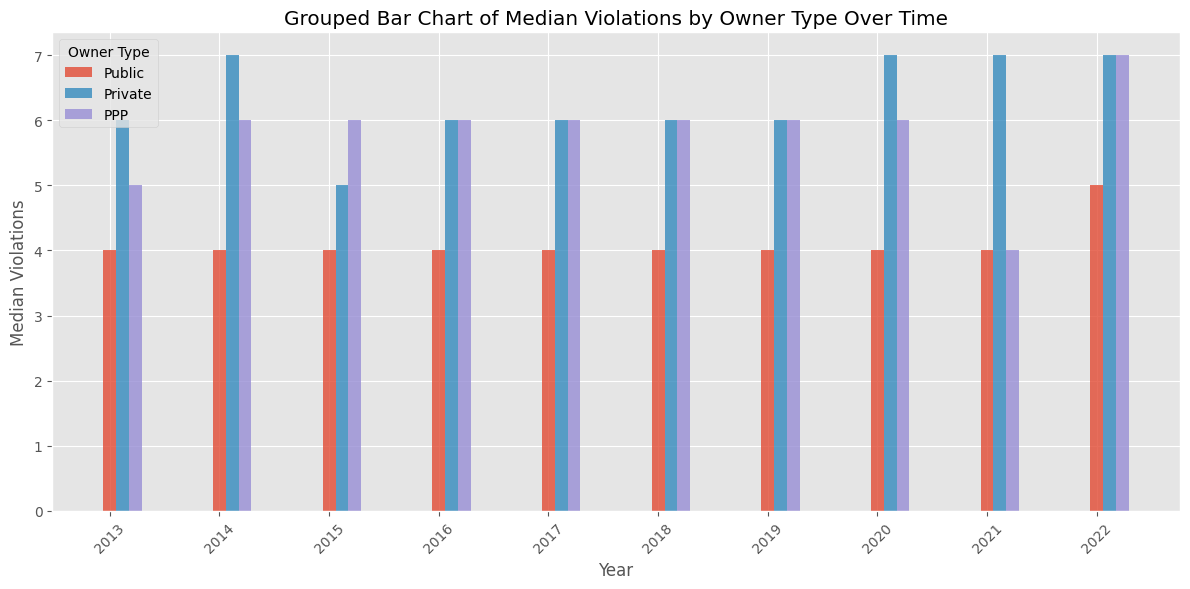

In [ ]:
# Pivot table of median violations by YEAR and OWNER_TYPE
median_violations_by_year = data.pivot_table(index='YEAR_FAC', columns='OWNER_TYPE', values='VIOLATIONS', aggfunc='median')

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.35
opacity = 0.8

# Convert years index to numeric type
years = median_violations_by_year.index.astype(int)
num_years = len(years)
num_owner_types = len(median_violations_by_year.columns)

for i, owner_type in enumerate(median_violations_by_year.columns):
    ax.bar(years + i * bar_width / num_owner_types, median_violations_by_year[owner_type],
           width=bar_width / num_owner_types, alpha=opacity, label=owner_type)

ax.set_xlabel('Year')
ax.set_ylabel('Median Violations')
ax.set_title('Grouped Bar Chart of Median Violations by Owner Type Over Time')
ax.set_xticks(years)
ax.set_xticklabels(years, rotation=45)
ax.legend(title='Owner Type')

plt.tight_layout()
plt.show()

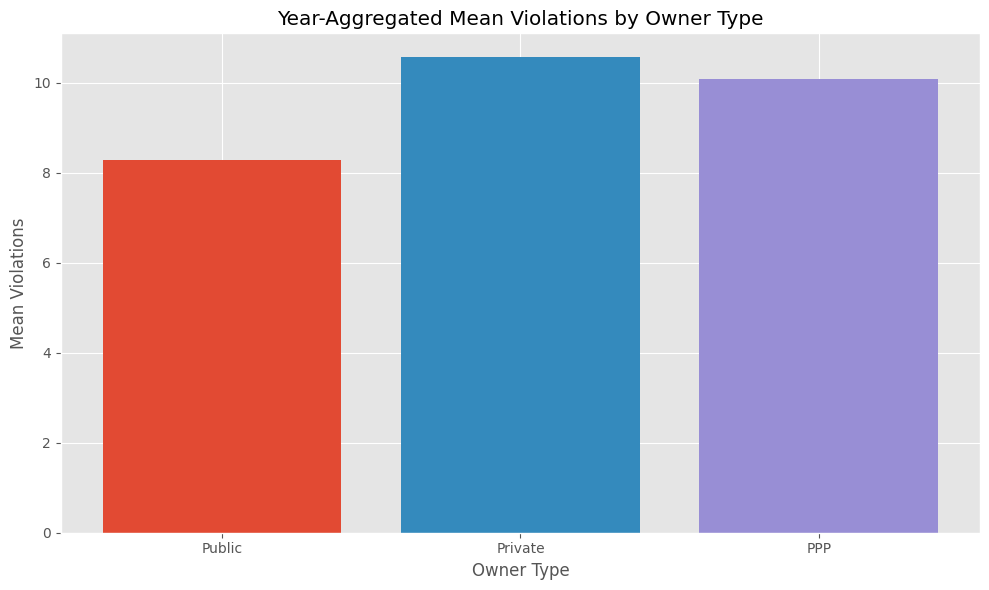

In [ ]:
# Bar plot of mean violations by OWNER_TYPE over all years
mean_violations_by_owner = data.groupby('OWNER_TYPE')['VIOLATIONS'].mean()
fig, ax = plt.subplots(figsize=(10, 6))

# Define a color for each owner type
owner_types = mean_violations_by_owner.index
colors = ['#E24A33', '#348ABD', '#988ED5']

ax.bar(owner_types, mean_violations_by_owner.values, color=colors[:len(owner_types)])
ax.set_xlabel('Owner Type')
ax.set_ylabel('Mean Violations')
ax.set_title('Year-Aggregated Mean Violations by Owner Type')
plt.tight_layout()
plt.show()

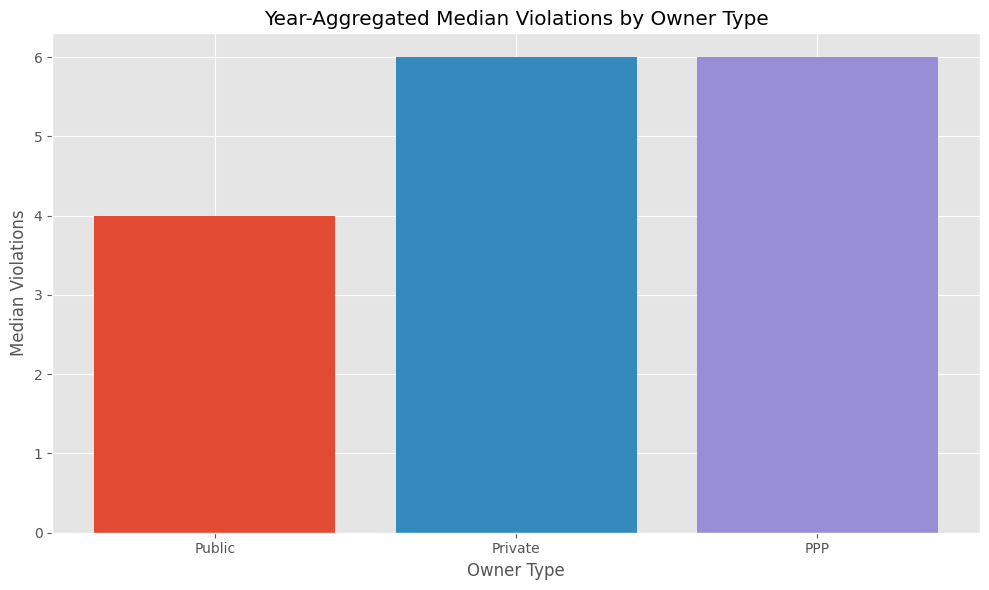

In [ ]:
# Bar plot of median violations by OWNER_TYPE over all years
median_violations_by_owner = data.groupby('OWNER_TYPE')['VIOLATIONS'].median()
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(owner_types, median_violations_by_owner.values, color=colors[:len(owner_types)])
ax.set_xlabel('Owner Type')
ax.set_ylabel('Median Violations')
ax.set_title('Year-Aggregated Median Violations by Owner Type')
plt.tight_layout()
plt.show()

# Distributional Analysis

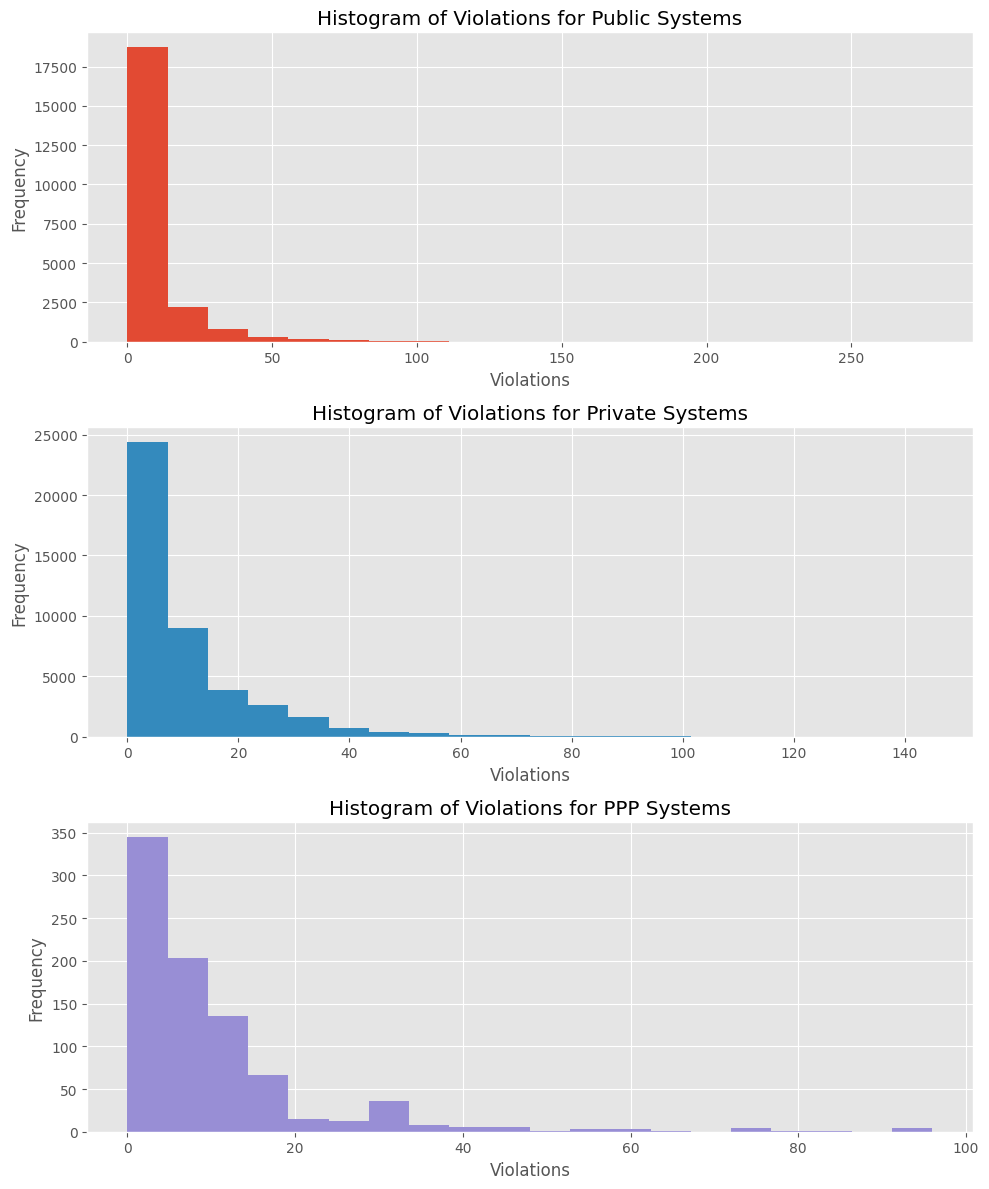

In [ ]:
# Histogram plots of violations by OWNER_TYPE over all years
fig, axes = plt.subplots(nrows=len(data['OWNER_TYPE'].unique()), figsize=(10, 12))

# Define a color for each owner type
owner_types = data['OWNER_TYPE'].cat.categories
colors = ['#E24A33', '#348ABD', '#988ED5']

for i, owner_type in enumerate(owner_types):
    axes[i].hist(data[data['OWNER_TYPE'] == owner_type]['VIOLATIONS'], bins=20, color=colors[i])
    axes[i].set_xlabel('Violations')
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Histogram of Violations for {owner_type} Systems')

plt.tight_layout()
plt.show()

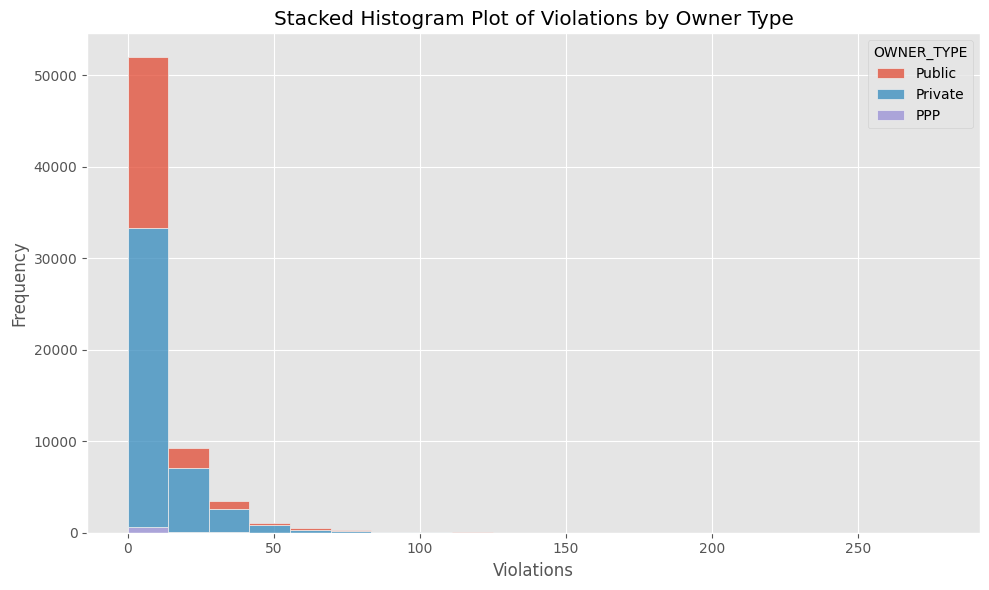

In [ ]:
# Stacked histogram plot of violations by OWNER_TYPE over all years
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='VIOLATIONS', hue='OWNER_TYPE', multiple='stack', bins=20)
plt.xlabel('Violations')
plt.ylabel('Frequency')
plt.title('Stacked Histogram Plot of Violations by Owner Type')
plt.tight_layout()
plt.show()

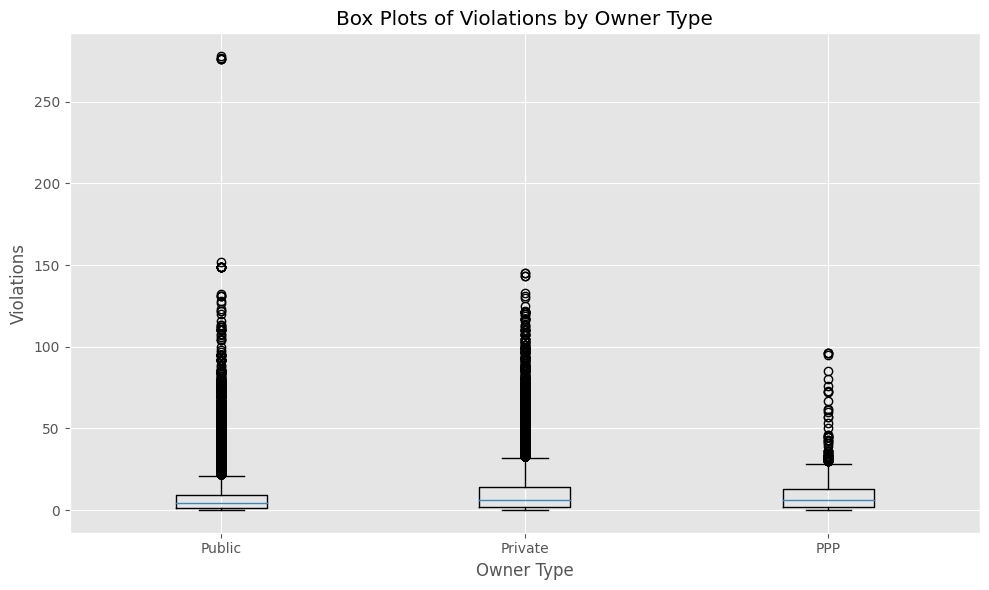

In [ ]:
# Box plots of violations over all years by OWNER_TYPE
plt.figure(figsize=(10, 6))
violations_data = [data[data['OWNER_TYPE'] == owner_type]['VIOLATIONS'] for owner_type in data['OWNER_TYPE'].cat.categories]
labels = data['OWNER_TYPE'].cat.categories
plt.boxplot(violations_data, labels=labels)
plt.xlabel('Owner Type')
plt.ylabel('Violations')
plt.title('Box Plots of Violations by Owner Type')
plt.tight_layout()
plt.show()

# Correlational Analysis

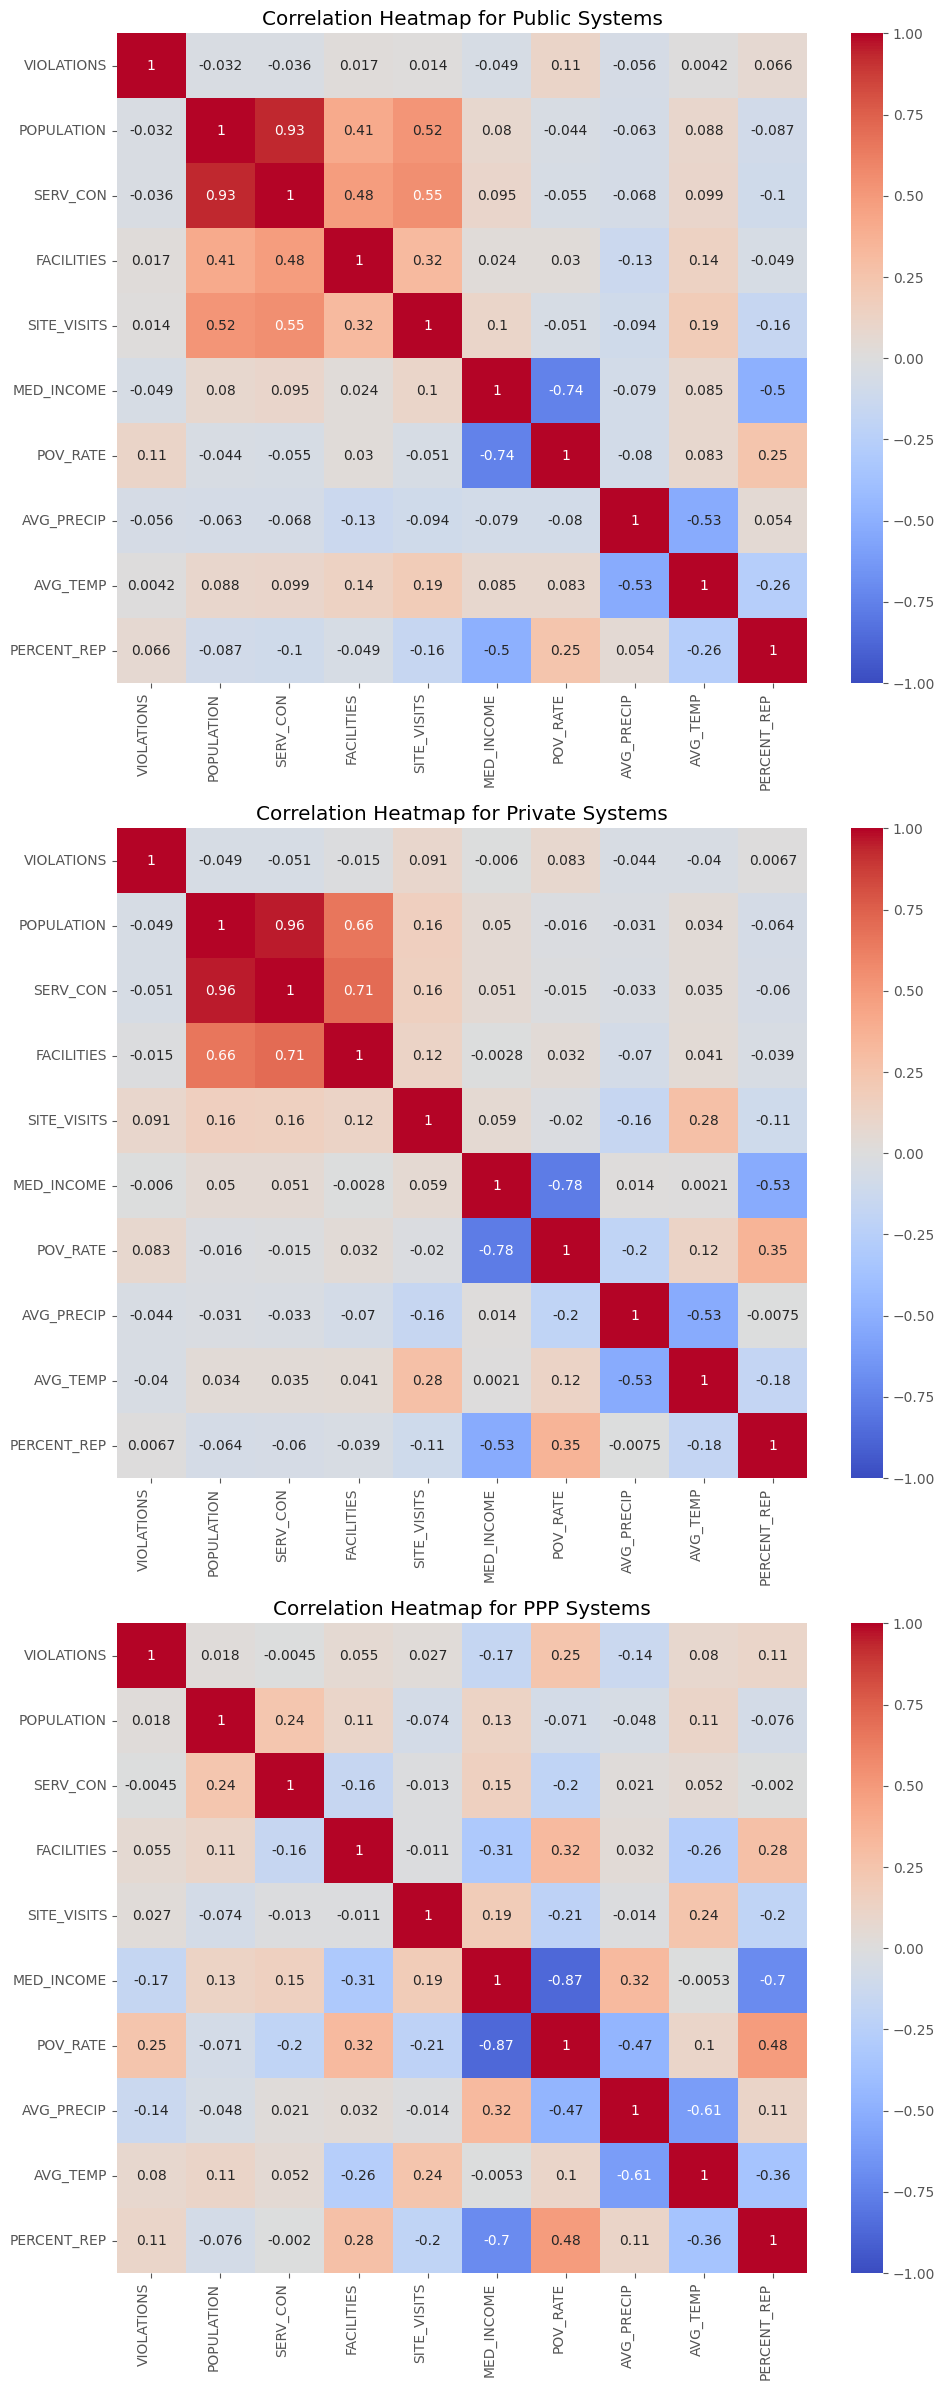

In [ ]:
# Heatmap of correlations by OWNER_TYPE over all years
corr_matrices = {}
numeric_vars = ['VIOLATIONS', 'POPULATION', 'SERV_CON', 'FACILITIES', 'SITE_VISITS',
                'MED_INCOME', 'POV_RATE', 'AVG_PRECIP', 'AVG_TEMP', 'PERCENT_REP']

for owner_type in data['OWNER_TYPE'].cat.categories:
    corr_matrices[owner_type] = data[data['OWNER_TYPE'] == owner_type][numeric_vars].corr()

fig, axes = plt.subplots(nrows=len(corr_matrices), figsize=(10, 8*len(corr_matrices)))

for i, (owner_type, corr_matrix) in enumerate(corr_matrices.items()):
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=axes[i], vmin=-1, vmax=1)
    axes[i].set_title(f'Correlation Heatmap for {owner_type} Systems')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90, ha='right')
    axes[i].set_yticklabels(axes[i].get_yticklabels(), rotation=0)

    # Save each heatmap as a separate image
    fig_individual, ax_individual = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax_individual, vmin=-1, vmax=1)
    ax_individual.set_title(f'Correlation Heatmap for {owner_type} Systems')
    ax_individual.set_xticklabels(ax_individual.get_xticklabels(), rotation=90, ha='right')
    ax_individual.set_yticklabels(ax_individual.get_yticklabels(), rotation=0)
    plt.tight_layout()
    plt.savefig(f'correlation_heatmap_{owner_type}.png')
    plt.close(fig_individual)

plt.tight_layout()
plt.show()

In [ ]:
# VIF table with numeric variables
vif = pd.DataFrame()
vif["Variables"] = numeric_vars
vif["VIF Factor"] = [variance_inflation_factor(data[numeric_vars].values, i) for i in range(len(numeric_vars))]
vif = vif.sort_values(by='VIF Factor', ascending=False)
vif.reset_index(drop=True, inplace=True)
print("\nVariance Inflation Factor (VIF) Table:")
vif


Variance Inflation Factor (VIF) Table:


,Variables,VIF Factor
0,AVG_TEMP,86.104334
1,MED_INCOME,28.126927
2,POV_RATE,21.983940
3,PERCENT_REP,13.613840
4,SERV_CON,8.721108
5,POPULATION,7.836127
6,AVG_PRECIP,2.712854
7,SITE_VISITS,2.182179
8,VIOLATIONS,1.602289
9,FACILITIES,1.585470


# County-Level Analysis

In [ ]:
# Load the California county shapefile
ca_counties = gpd.read_file('https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/california-counties.geojson')

# Rename the 'name' column to 'COUNTY' to match
ca_counties.rename(columns={'name': 'COUNTY'}, inplace=True)

# Convert 'created_at' and 'updated_at' columns to strings
ca_counties['created_at'] = ca_counties['created_at'].astype(str)
ca_counties['updated_at'] = ca_counties['updated_at'].astype(str)

In [ ]:
# Calculate the mean violations by county across all years
mean_violations_by_county = data.groupby('COUNTY')['VIOLATIONS'].mean().reset_index()

# Merge the mean violations data with the county shapefile
ca_counties_merged = ca_counties.merge(mean_violations_by_county, on='COUNTY')

In [ ]:
# Create a choropleth map for mean violations by county
m = folium.Map(location=[37.7749, -122.4194], zoom_start=6)

folium.Choropleth(
    geo_data=ca_counties_merged,
    name='Mean Violations',
    data=ca_counties_merged,
    columns=['COUNTY', 'VIOLATIONS'],
    key_on='feature.properties.COUNTY',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Mean Violations by County'
).add_to(m)

# Display the map
display(m)

In [ ]:
# Save the map to an HTML file
m.save('ca_county_map_mean_violations.html')

In [ ]:
# Load the California county shapefile
ca_counties = gpd.read_file('https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/california-counties.geojson')

# Rename the 'name' column to 'COUNTY' to match
ca_counties.rename(columns={'name': 'COUNTY'}, inplace=True)

# Convert 'created_at' and 'updated_at' columns to strings
ca_counties['created_at'] = ca_counties['created_at'].astype(str)
ca_counties['updated_at'] = ca_counties['updated_at'].astype(str)

In [ ]:
# Calculate the median violations by county across all years
median_violations_by_county = data.groupby('COUNTY')['VIOLATIONS'].median().reset_index()

# Merge the median violations data with the county shapefile
ca_counties_merged = ca_counties.merge(median_violations_by_county, on='COUNTY')

In [ ]:
# Create a choropleth map for median violations by county
m = folium.Map(location=[37.7749, -122.4194], zoom_start=6)

folium.Choropleth(
    geo_data=ca_counties_merged,
    name='Median Violations',
    data=ca_counties_merged,
    columns=['COUNTY', 'VIOLATIONS'],
    key_on='feature.properties.COUNTY',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Median Violations by County'
).add_to(m)

# Display the map
display(m)

In [ ]:
# Save the map to an HTML file
m.save('ca_county_map_median_violations.html')

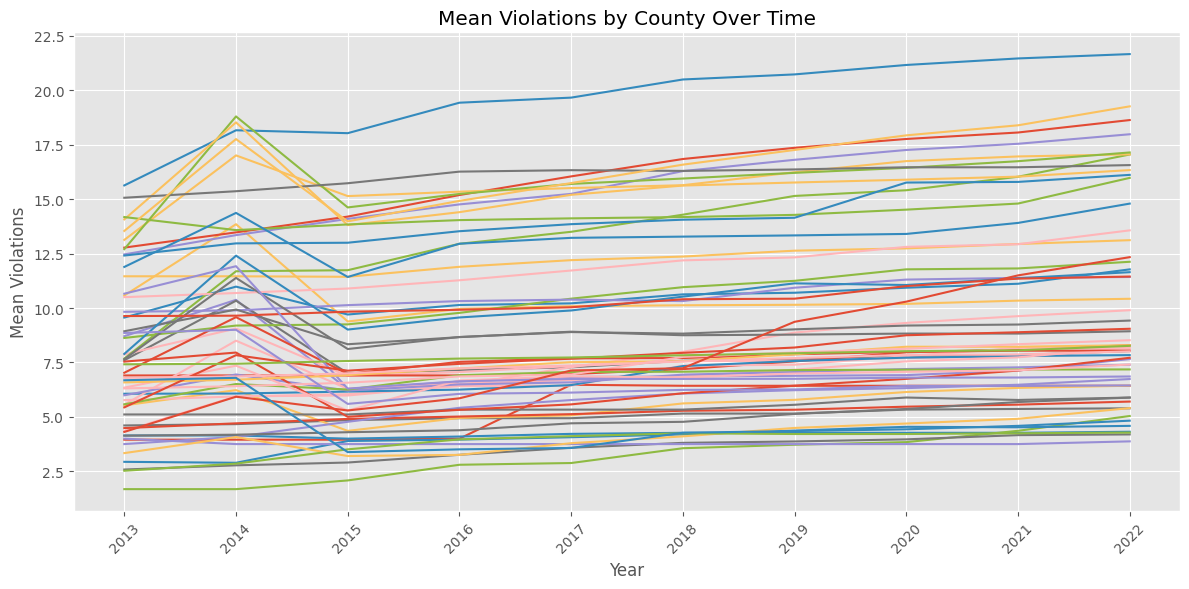

In [ ]:
# Time series plot of mean violations by COUNTY over all years, without legend
fig, ax = plt.subplots(figsize=(12, 6))
for county in data['COUNTY'].unique():
    violations_data = data[data['COUNTY'] == county].groupby('YEAR_FAC')['VIOLATIONS'].mean()
    ax.plot(violations_data.index, violations_data.values)
ax.set_xlabel('Year')
ax.set_ylabel('Mean Violations')
ax.set_title('Mean Violations by County Over Time')
ax.set_xticks(data['YEAR_FAC'].unique())
ax.set_xticklabels(data['YEAR_FAC'].unique(), rotation=45)
plt.tight_layout()
plt.show()

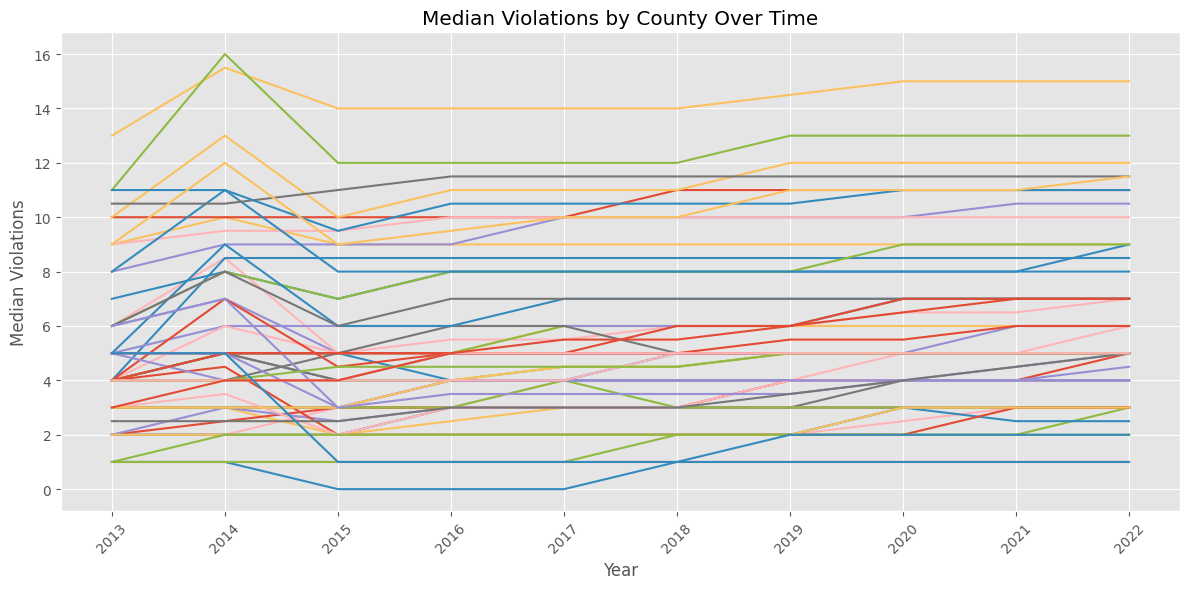

In [ ]:
# Time series plot of median violations by COUNTY over all years, without legend
fig, ax = plt.subplots(figsize=(12, 6))
for county in data['COUNTY'].unique():
    violations_data = data[data['COUNTY'] == county].groupby('YEAR_FAC')['VIOLATIONS'].median()
    ax.plot(violations_data.index, violations_data.values)
ax.set_xlabel('Year')
ax.set_ylabel('Median Violations')
ax.set_title('Median Violations by County Over Time')
ax.set_xticks(data['YEAR_FAC'].unique())
ax.set_xticklabels(data['YEAR_FAC'].unique(), rotation=45)
plt.tight_layout()
plt.show()

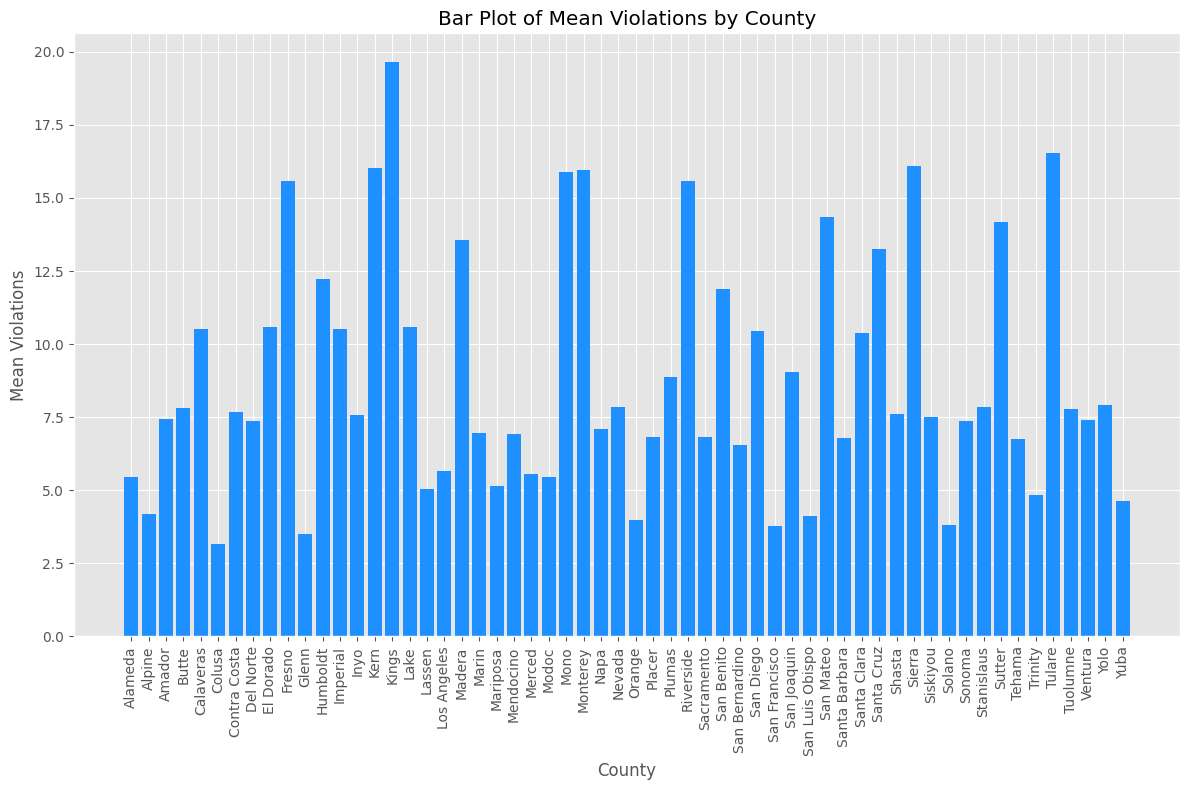

In [ ]:
# Bar plot of mean violations by COUNTY over all years
mean_violations_by_county = data.groupby('COUNTY')['VIOLATIONS'].mean()
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(mean_violations_by_county.index, mean_violations_by_county.values, color='dodgerblue')
ax.set_xlabel('County')
ax.set_ylabel('Mean Violations')
ax.set_title('Bar Plot of Mean Violations by County')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

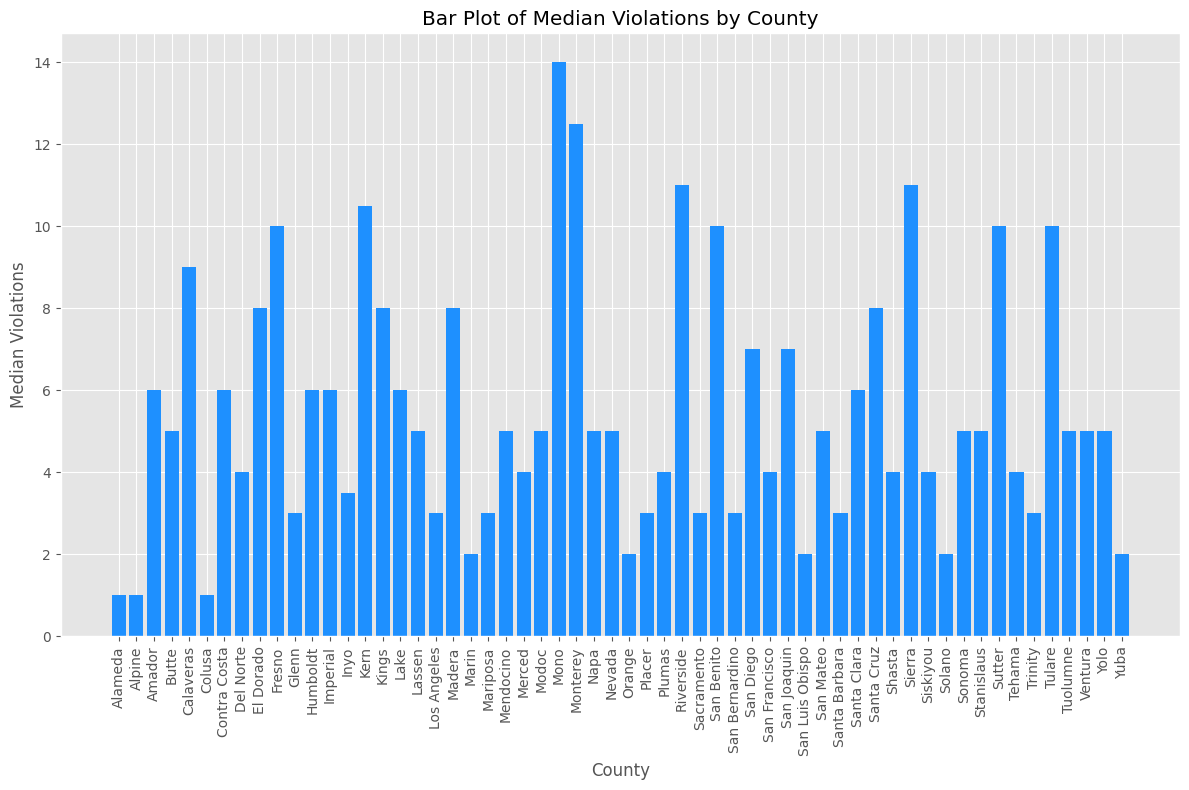

In [ ]:
# Bar plot of median violations by COUNTY over all years
median_violations_by_county = data.groupby('COUNTY')['VIOLATIONS'].median()
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(median_violations_by_county.index, median_violations_by_county.values, color='dodgerblue')
ax.set_xlabel('County')
ax.set_ylabel('Median Violations')
ax.set_title('Bar Plot of Median Violations by County')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# System-Level Analysis

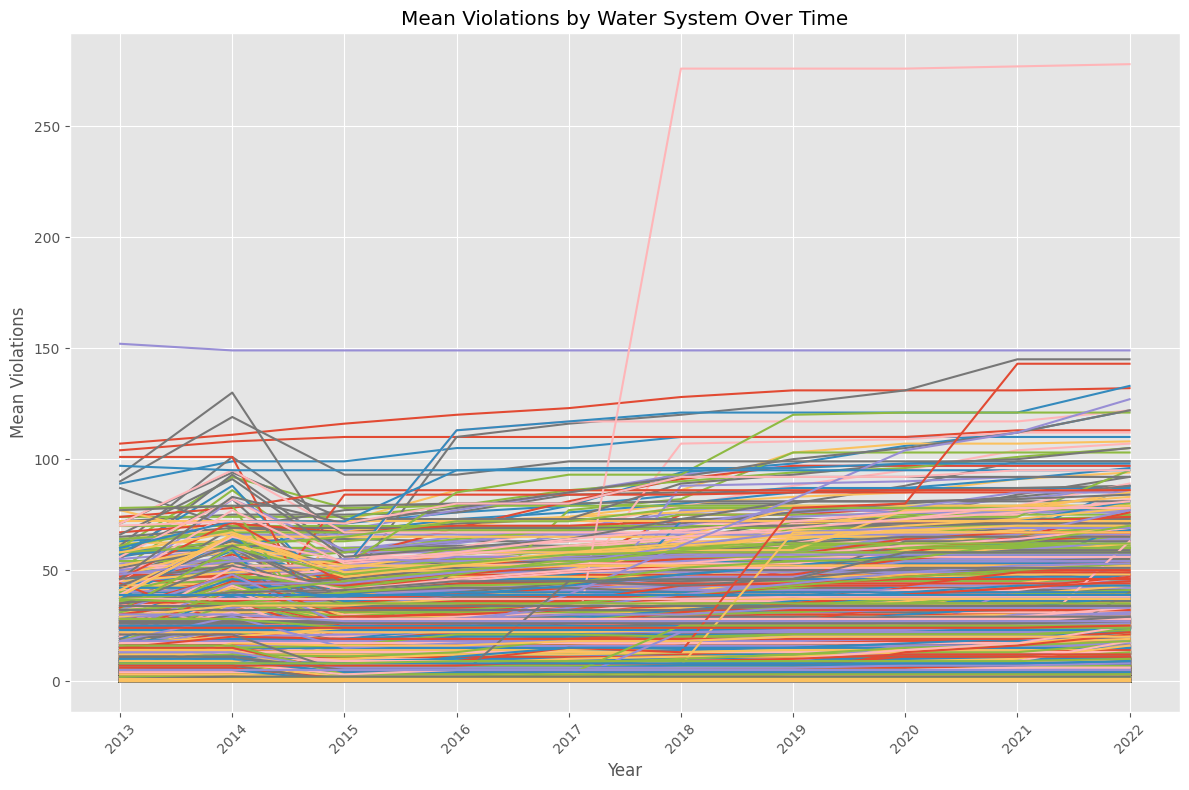

In [ ]:
# Time series plot of mean violations by PWS_ID over all years
fig, ax = plt.subplots(figsize=(12, 8))
for pws_id in data['PWS_ID'].unique():
    violations_data = data[data['PWS_ID'] == pws_id].groupby('YEAR_FAC')['VIOLATIONS'].mean()
    ax.plot(violations_data.index, violations_data.values)
ax.set_xlabel('Year')
ax.set_ylabel('Mean Violations')
ax.set_title('Mean Violations by Water System Over Time')
ax.set_xticks(data['YEAR_FAC'].unique())
ax.set_xticklabels(data['YEAR_FAC'].unique(), rotation=45)
plt.tight_layout()
plt.show()

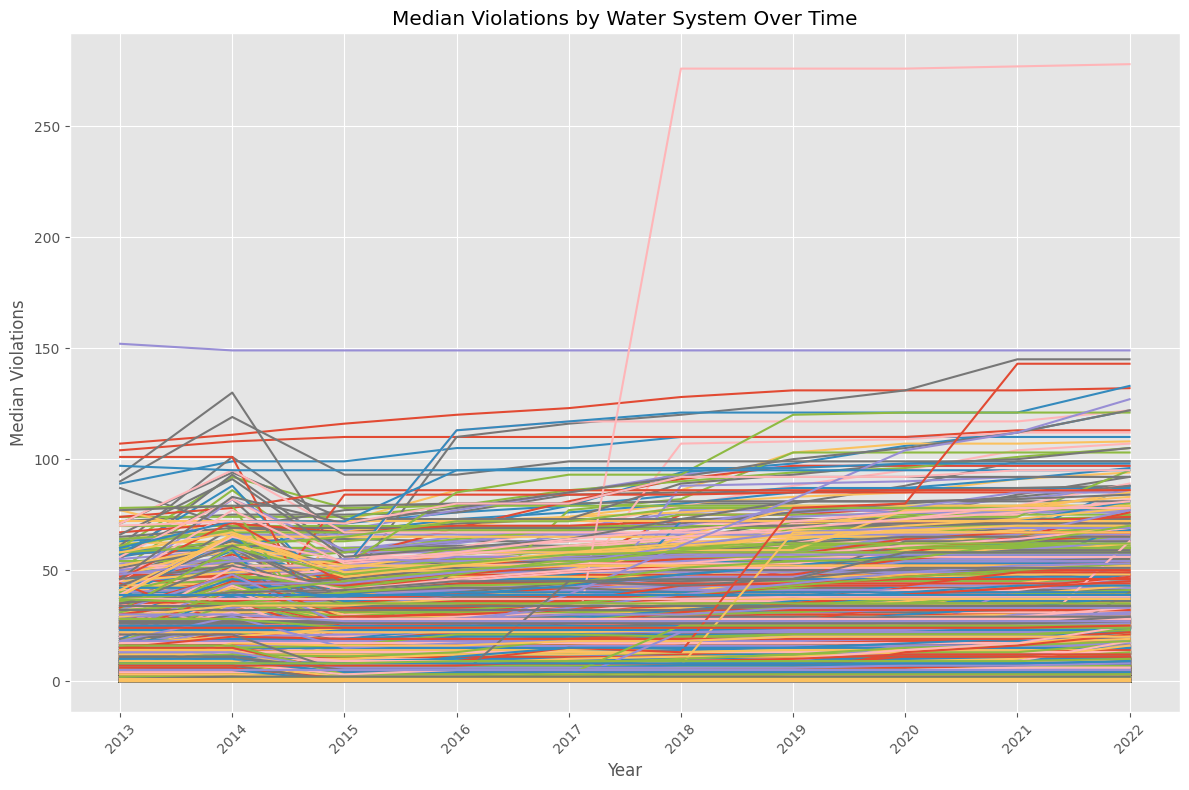

In [ ]:
# Time series plot of median violations by PWS_ID over all years
fig, ax = plt.subplots(figsize=(12, 8))
for pws_id in data['PWS_ID'].unique():
    violations_data = data[data['PWS_ID'] == pws_id].groupby('YEAR_FAC')['VIOLATIONS'].median()
    ax.plot(violations_data.index, violations_data.values)
ax.set_xlabel('Year')
ax.set_ylabel('Median Violations')
ax.set_title('Median Violations by Water System Over Time')
ax.set_xticks(data['YEAR_FAC'].unique())
ax.set_xticklabels(data['YEAR_FAC'].unique(), rotation=45)
plt.tight_layout()
plt.show()

# Overdispersion Check

In [ ]:
# Ratio of variance to mean
mean_violations = data['VIOLATIONS'].mean()
variance_violations = data['VIOLATIONS'].var()
variance_mean_ratio = variance_violations / mean_violations
print(f"Mean Violations: {mean_violations}")
print(f"Variance of Violations: {variance_violations}")
print(f"Variance to Mean Ratio: {variance_mean_ratio:.2f}")

Mean Violations: 9.792077280215667
Variance of Violations: 171.8961854884937
Variance to Mean Ratio: 17.55


# Zero-Inflation Check

In [ ]:
# Proportion of zero counts
zero_proportion = (data['VIOLATIONS'] == 0).mean()
print(f"Proportion of Zero Counts: {zero_proportion:.4f}")

Proportion of Zero Counts: 0.1072


In [ ]:
# Comparison with expected proportion of ones in a Poisson distribution
mean_violations = data['VIOLATIONS'].mean()
poisson_zero_proportion = poisson.pmf(0, mu=mean_violations)
print(f"Expected Proportion of Zeros in Poisson Distribution: {poisson_zero_proportion:.4f}")

Expected Proportion of Zeros in Poisson Distribution: 0.0001


In [ ]:
# Calculate the parameters of the Negative Binomial distribution
p = mean_violations / variance_violations
r = mean_violations ** 2 / (variance_violations - mean_violations)

# Calculate the expected proportion of zeros using the Negative Binomial PMF
nb_zero_proportion = nbinom.pmf(k=0, n=r, p=p)

print(f"Expected Proportion of Zeros in Negative Binomial Distribution: {nb_zero_proportion:.4f}")

Expected Proportion of Zeros in Negative Binomial Distribution: 0.1836


In [ ]:
# Proportion of zeros by OWNER_TYPE
zero_proportion_by_owner = data.groupby('OWNER_TYPE')['VIOLATIONS'].apply(lambda x: (x == 0).mean()).reset_index()
zero_proportion_by_owner.columns = ['OWNER_TYPE', 'ZERO_PROPORTION']
print(zero_proportion_by_owner)

  OWNER_TYPE  ZERO_PROPORTION
0     Public         0.135474
1    Private         0.092728
2        PPP         0.105634


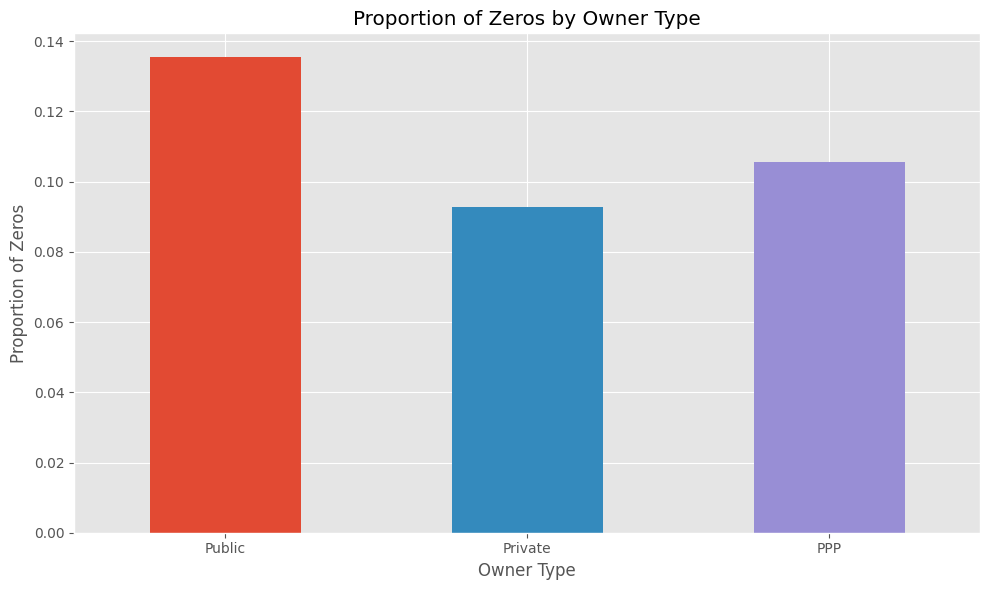

In [ ]:
# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
zero_proportion_by_owner.plot(kind='bar', x='OWNER_TYPE', y='ZERO_PROPORTION', legend=False, color=colors, ax=ax)

ax.set_xticklabels(zero_proportion_by_owner['OWNER_TYPE'], rotation=0)
ax.set_xlabel('Owner Type')
ax.set_ylabel('Proportion of Zeros')
ax.set_title('Proportion of Zeros by Owner Type')

plt.tight_layout()
plt.show()

In [ ]:
# Percent contribution of each OWNER_TYPE to the zero counts
zero_proportion_by_owner['PERCENT_CONTRIBUTION'] = (zero_proportion_by_owner['ZERO_PROPORTION'] / zero_proportion_by_owner['ZERO_PROPORTION'].sum()) * 100
print(zero_proportion_by_owner)

  OWNER_TYPE  ZERO_PROPORTION  PERCENT_CONTRIBUTION
0     Public         0.135474             40.581045
1    Private         0.092728             27.776452
2        PPP         0.105634             31.642503


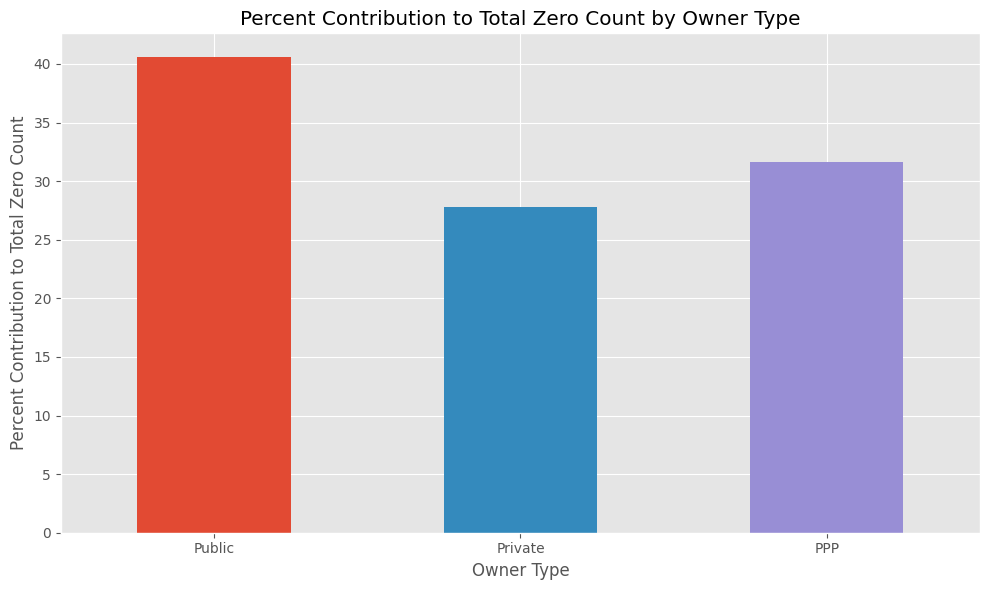

In [ ]:
# Plot percent contribution to total zero count by OWNER_TYPE
fig, ax = plt.subplots(figsize=(10, 6))
zero_proportion_by_owner.plot(kind='bar', x='OWNER_TYPE', y='PERCENT_CONTRIBUTION', legend=False, color=colors, ax=ax)

ax.set_xticklabels(zero_proportion_by_owner['OWNER_TYPE'], rotation=0)
ax.set_xlabel('Owner Type')
ax.set_ylabel('Percent Contribution to Total Zero Count')
ax.set_title('Percent Contribution to Total Zero Count by Owner Type')

plt.tight_layout()
plt.show()

# One-Inflation Check

In [ ]:
# Proportion of one counts
one_proportion = (data['VIOLATIONS'] == 1).mean()
print(f"Proportion of One Counts: {one_proportion:.4f}")

Proportion of One Counts: 0.0964


In [ ]:
# Comparison with expected proportion of ones in a Poisson distribution
mean_violations = data['VIOLATIONS'].mean()
poisson_one_proportion = poisson.pmf(1, mu=mean_violations)
print(f"Expected Proportion of Ones in Poisson Distribution: {poisson_one_proportion:.4f}")

Expected Proportion of Ones in Poisson Distribution: 0.0005


In [ ]:
# Calculate the parameters of the Negative Binomial distribution
if variance_violations > mean_violations:
    p = mean_violations / variance_violations
    r = mean_violations ** 2 / (variance_violations - mean_violations)

    # Calculate the expected proportion of ones using the Negative Binomial PMF
    nb_one_proportion = nbinom.pmf(1, n=r, p=p)
    print(f"Expected Proportion of Ones in Negative Binomial Distribution: {nb_one_proportion:.4f}")
else:
    print("Variance is not greater than mean, Negative Binomial not appropriate.")

Expected Proportion of Ones in Negative Binomial Distribution: 0.1024


In [ ]:
# Proportion of ones by OWNER_TYPE
one_proportion_by_owner = data.groupby('OWNER_TYPE')['VIOLATIONS'].apply(lambda x: (x == 1).mean()).reset_index()
one_proportion_by_owner.columns = ['OWNER_TYPE', 'ONE_PROPORTION']
print(one_proportion_by_owner)

  OWNER_TYPE  ONE_PROPORTION
0     Public        0.127670
1    Private        0.080726
2        PPP        0.076291


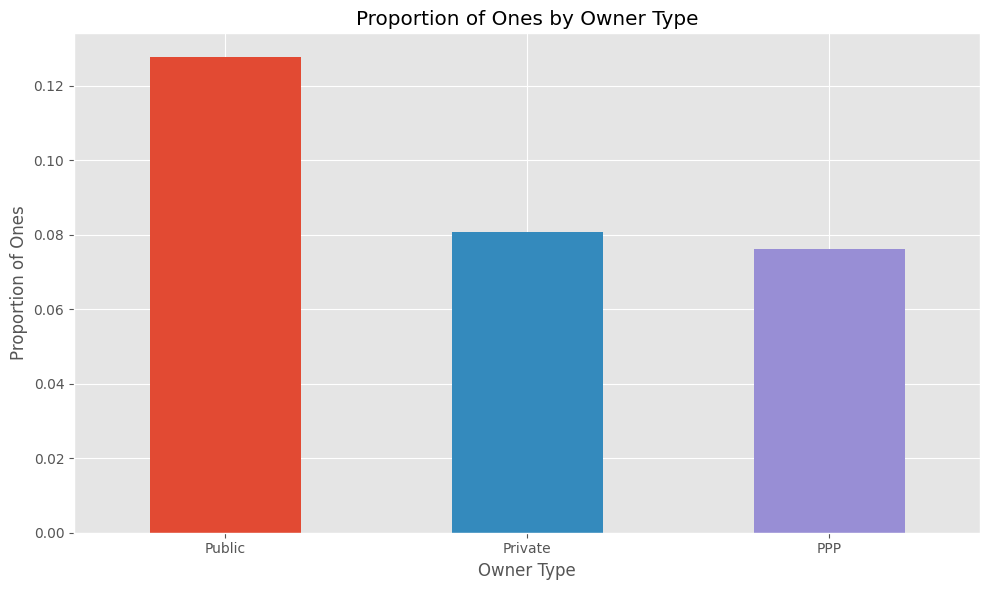

In [ ]:
# Plot the bar chart for proportion of ones
fig, ax = plt.subplots(figsize=(10, 6))
one_proportion_by_owner.plot(kind='bar', x='OWNER_TYPE', y='ONE_PROPORTION', legend=False, color=colors, ax=ax)

ax.set_xticklabels(one_proportion_by_owner['OWNER_TYPE'], rotation=0)
ax.set_xlabel('Owner Type')
ax.set_ylabel('Proportion of Ones')
ax.set_title('Proportion of Ones by Owner Type')

plt.tight_layout()
plt.show()

In [ ]:
# Percent contribution of each OWNER_TYPE to the one counts
one_proportion_by_owner['PERCENT_CONTRIBUTION'] = (one_proportion_by_owner['ONE_PROPORTION'] / one_proportion_by_owner['ONE_PROPORTION'].sum()) * 100
print(one_proportion_by_owner)

  OWNER_TYPE  ONE_PROPORTION  PERCENT_CONTRIBUTION
0     Public        0.127670             44.845790
1    Private        0.080726             28.355953
2        PPP        0.076291             26.798257


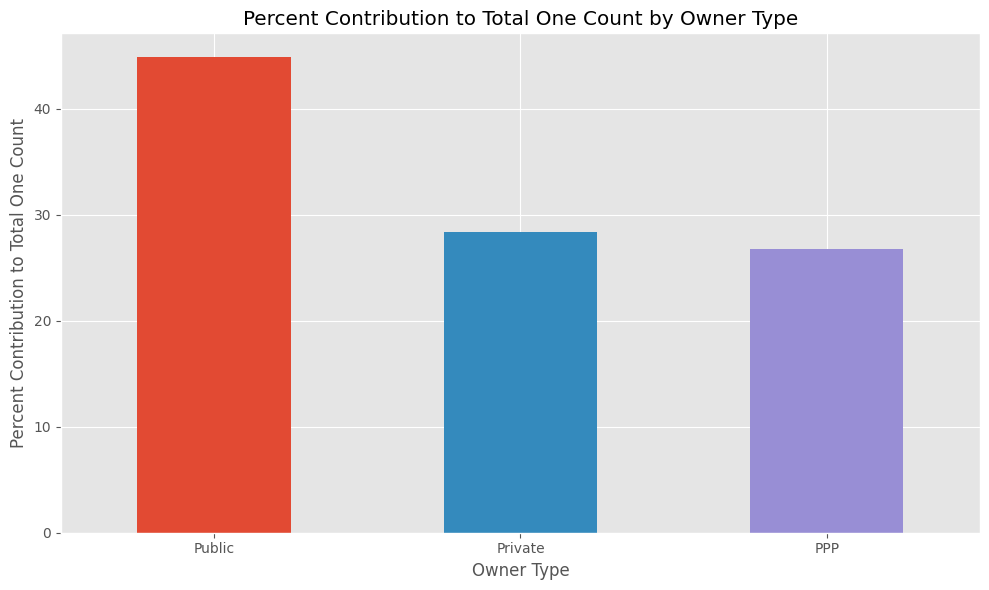

In [ ]:
# Plot percent contribution to total one count by OWNER_TYPE
fig, ax = plt.subplots(figsize=(10, 6))
one_proportion_by_owner.plot(kind='bar', x='OWNER_TYPE', y='PERCENT_CONTRIBUTION', legend=False, color=colors, ax=ax)

ax.set_xticklabels(one_proportion_by_owner['OWNER_TYPE'], rotation=0)
ax.set_xlabel('Owner Type')
ax.set_ylabel('Percent Contribution to Total One Count')
ax.set_title('Percent Contribution to Total One Count by Owner Type')

plt.tight_layout()
plt.show()

# Population Served Variability

In [ ]:
# Overall variability of POPULATION
overall_variability = data['POPULATION'].var()
print(f"Overall variability of POPULATION: {overall_variability:.2f}")

Overall variability of POPULATION: 4242424426.86


In [ ]:
# Within-county variability of POPULATION
within_county_variability = data.groupby('COUNTY')['POPULATION'].var()
print("Variability of POPULATION within each county:")
print(within_county_variability)

Variability of POPULATION within each county:
COUNTY
Alameda            9.068662e+10
Alpine             9.067937e+05
Amador             4.300516e+06
Butte              1.446347e+08
Calaveras          1.003359e+07
Colusa             1.273624e+07
Contra Costa       6.859203e+08
Del Norte          6.435407e+06
El Dorado          1.701955e+08
Fresno             9.681557e+08
Glenn              6.121058e+06
Humboldt           5.817664e+07
Imperial           7.178417e+07
Inyo               2.599577e+06
Kern               3.098863e+08
Kings              1.371252e+08
Lake               3.057935e+06
Lassen             5.134993e+06
Los Angeles        5.929730e+10
Madera             2.423211e+07
Marin              8.229793e+08
Mariposa           7.822139e+05
Mendocino          3.850850e+06
Merced             1.117867e+08
Modoc              7.029628e+05
Mono               4.833853e+06
Monterey           7.968715e+07
Napa               7.088922e+07
Nevada             1.426421e+07
Orange             

In [ ]:
# Between-county variability of POPULATION
between_county_variability = data.groupby('COUNTY')['POPULATION'].mean().var()
print(f"Variability of POPULATION between counties: {between_county_variability:.2f}")

Variability of POPULATION between counties: 556744068.11


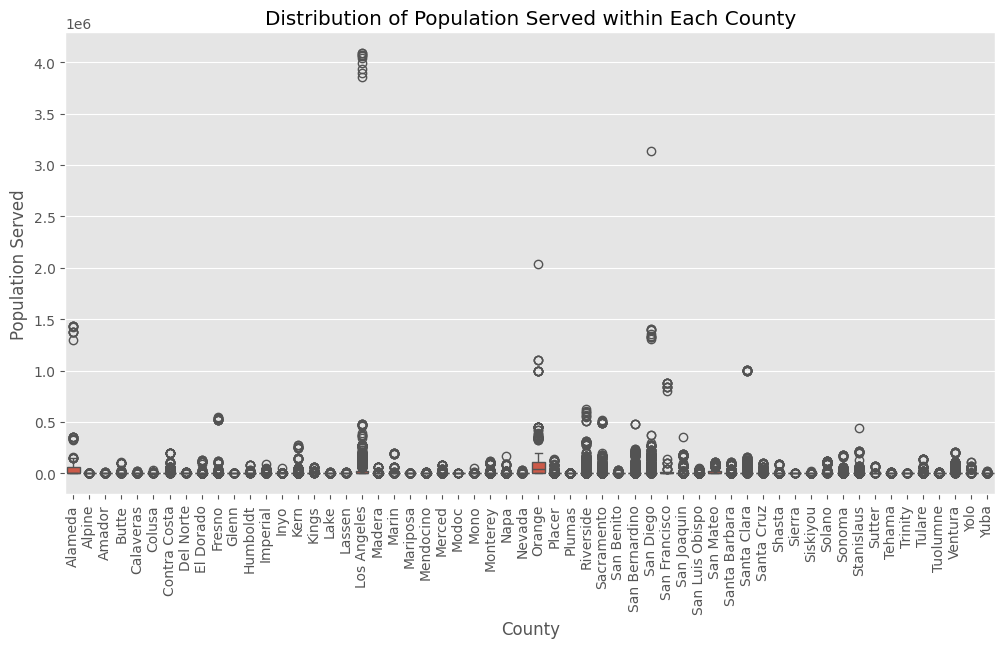

In [ ]:
# Distribution of POPULATION within each county
plt.figure(figsize=(12, 6))
sns.boxplot(x='COUNTY', y='POPULATION', data=data)
plt.xticks(rotation=90)
plt.xlabel('County')
plt.ylabel('Population Served')
plt.title('Distribution of Population Served within Each County')
plt.show()

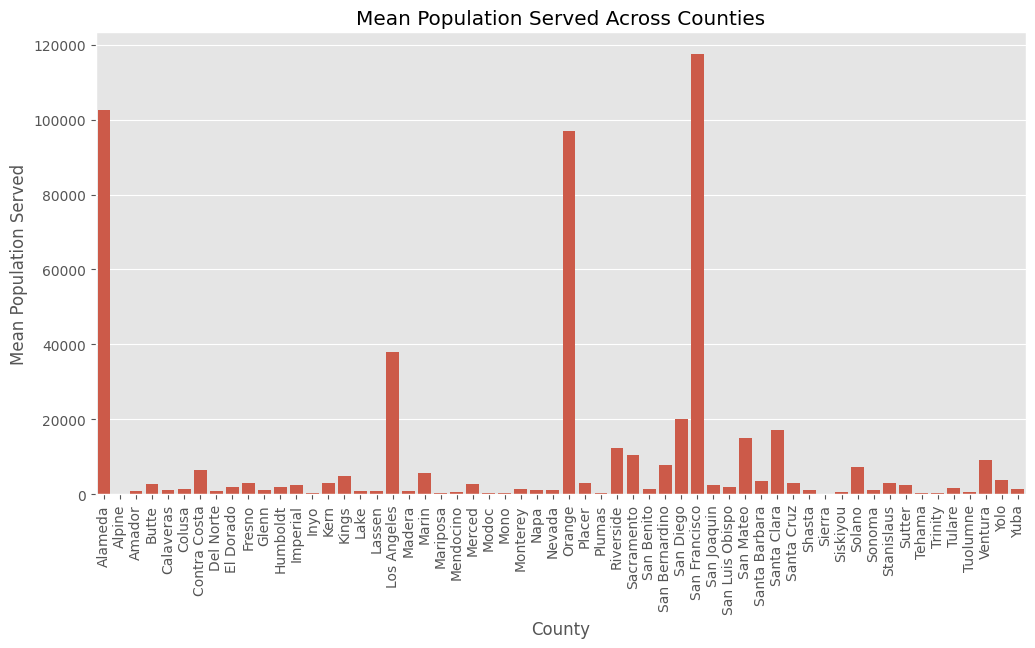

In [ ]:
# Mean POPULATION across counties
county_means = data.groupby('COUNTY')['POPULATION'].mean()

plt.figure(figsize=(12, 6))
sns.barplot(x=county_means.index, y=county_means.values)
plt.xticks(rotation=90)
plt.xlabel('County')
plt.ylabel('Mean Population Served')
plt.title('Mean Population Served Across Counties')
plt.show()

In [ ]:
# One-way ANOVA test for significant differences between counties
counties = data['COUNTY'].unique()
county_data = [data[data['COUNTY'] == county]['POPULATION'] for county in counties]

f_statistic, p_value = stats.f_oneway(*county_data)
print(f"One-way ANOVA results:")
print(f"F-statistic: {f_statistic:.2f}")
print(f"p-value: {p_value:.4f}")

One-way ANOVA results:
F-statistic: 48.26
p-value: 0.0000


In [ ]:
# Overall correlation between POPULATION and VIOLATIONS
overall_correlation = data['POPULATION'].corr(data['VIOLATIONS'])
print(f"Overall correlation between POPULATION and VIOLATIONS: {overall_correlation:.2f}")

Overall correlation between POPULATION and VIOLATIONS: -0.04


In [ ]:
# Within-county correlation between the variables
within_county_correlation = data.groupby('COUNTY')[['POPULATION', 'VIOLATIONS']].corr().unstack().iloc[:, 1]
print("Correlation between POPULATION and VIOLATIONS within each county:")
print(within_county_correlation)

Correlation between POPULATION and VIOLATIONS within each county:
COUNTY
Alameda           -0.045419
Alpine            -0.010139
Amador             0.074959
Butte             -0.091695
Calaveras         -0.224201
Colusa            -0.062945
Contra Costa      -0.126329
Del Norte         -0.204414
El Dorado         -0.070641
Fresno            -0.032178
Glenn              0.012248
Humboldt          -0.180962
Imperial          -0.053166
Inyo              -0.026414
Kern              -0.011622
Kings              0.644699
Lake              -0.304978
Lassen             0.096664
Los Angeles       -0.024865
Madera            -0.022754
Marin             -0.097453
Mariposa           0.142589
Mendocino         -0.105350
Merced            -0.013451
Modoc              0.019794
Mono              -0.067975
Monterey          -0.087801
Napa               0.011700
Nevada            -0.200307
Orange            -0.130009
Placer            -0.107578
Plumas             0.013311
Riverside         -0.117914
Sac

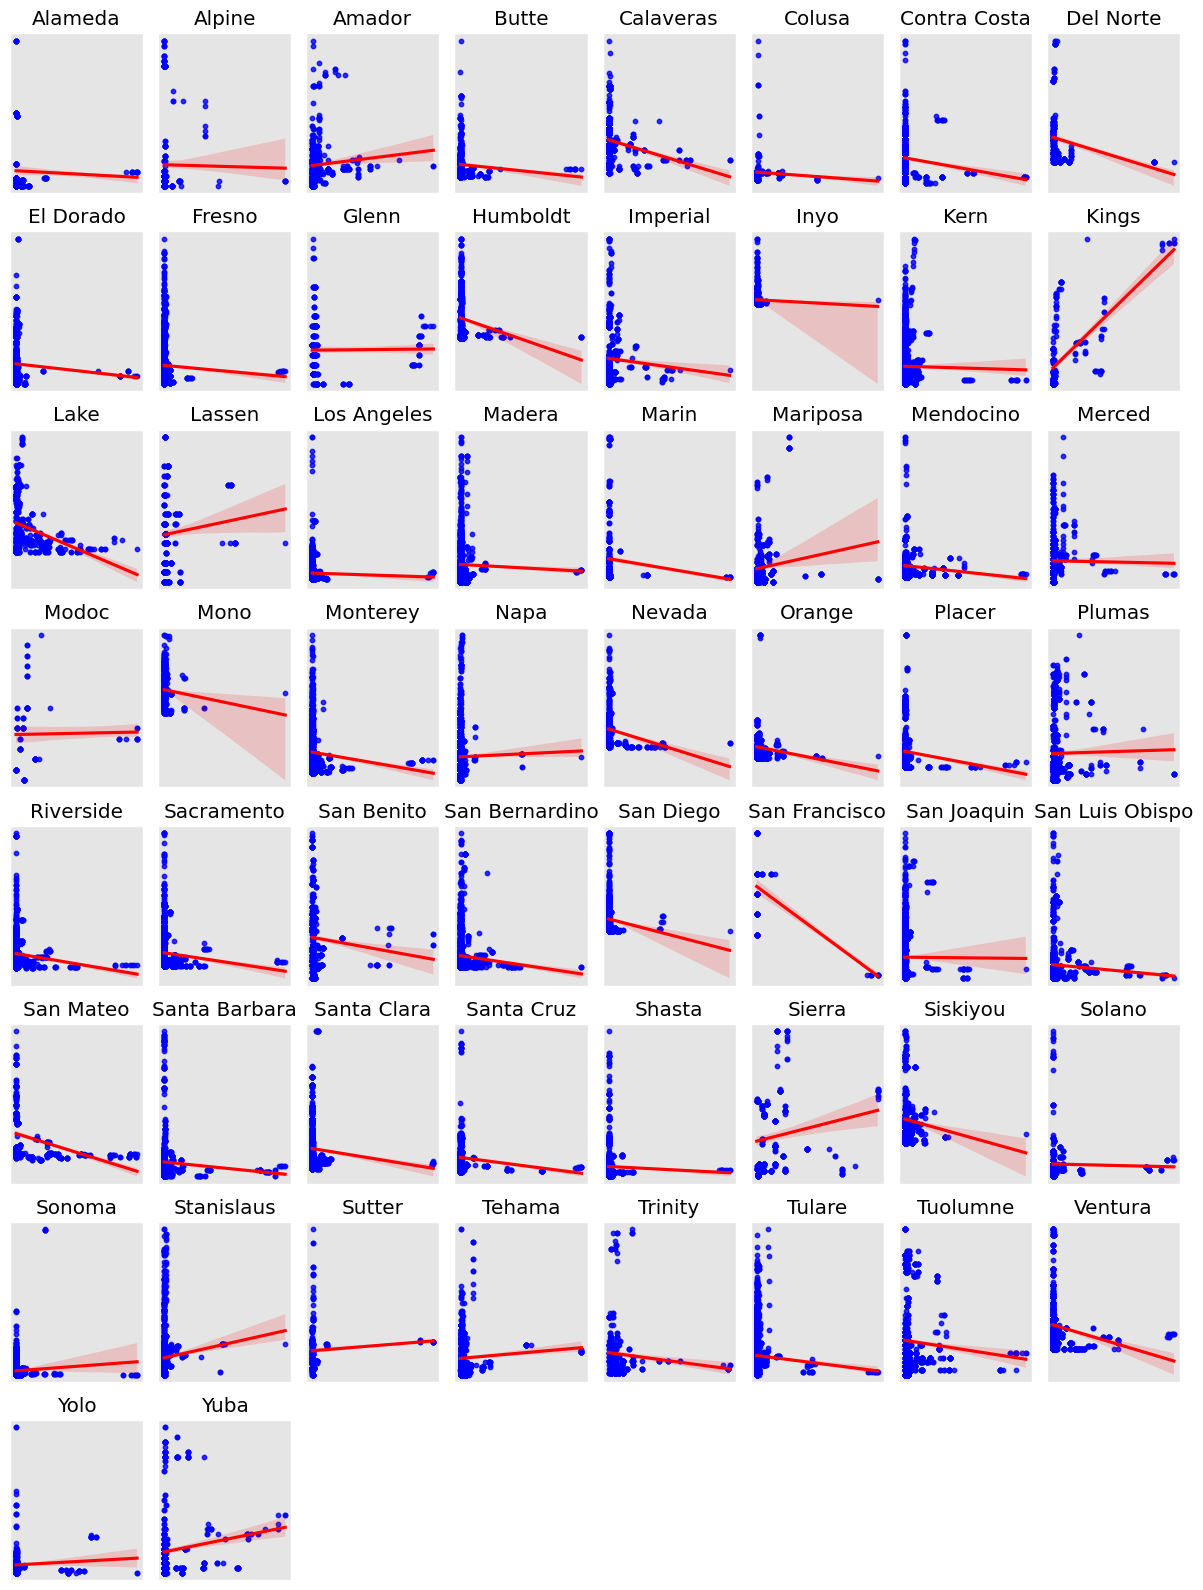

In [ ]:
# County-specific scatterplots
counties = data['COUNTY'].unique()

plt.figure(figsize=(12, 16))
for i, county in enumerate(counties, 1):
    plt.subplot(8, 8, i)
    county_data = data[data['COUNTY'] == county]
    sns.regplot(x='POPULATION', y='VIOLATIONS', data=county_data, color='b', scatter_kws={'s': 10}, line_kws={'color': 'r'})
    plt.title(county)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha no

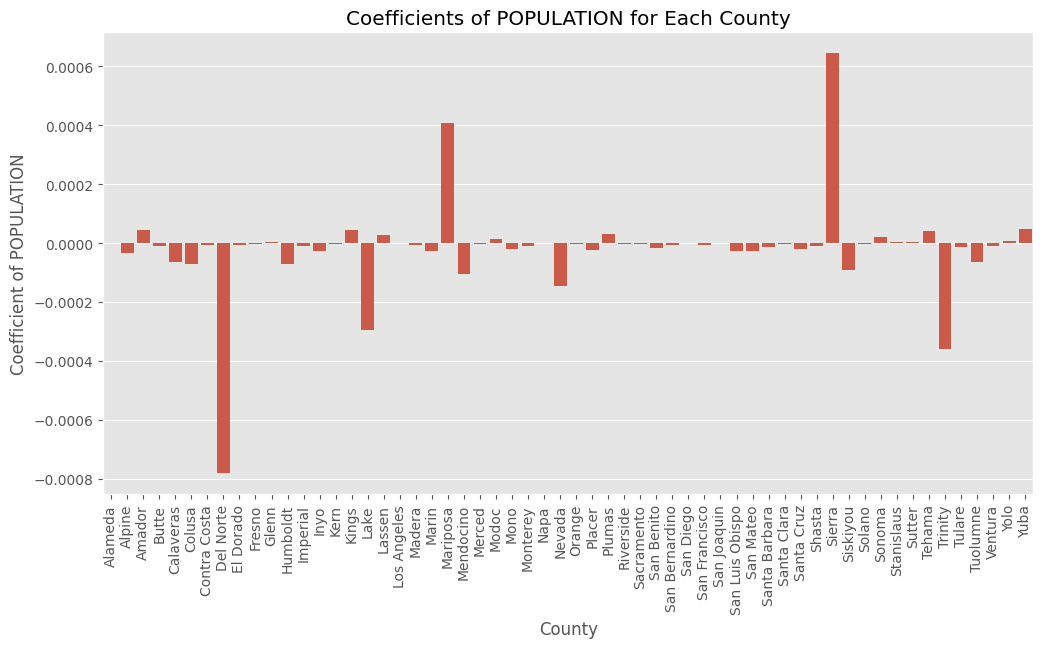

In [ ]:
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import NegativeBinomial
from statsmodels.formula.api import glm

# Function to perform negative binomial regression
# Will get warnings because statsmodels does not yet allow dispersion parameter to be stochastic
def negative_binomial_regression(data):
    # Fit the negative binomial regression model using formula
    model = glm('VIOLATIONS ~ POPULATION', data=data, family=NegativeBinomial())
    results = model.fit()

    return results.params['POPULATION']  # Return the coefficient for POPULATION

county_coefficients = {}

for county in counties:
    county_data = data[data['COUNTY'] == county]

    coef = negative_binomial_regression(county_data)
    county_coefficients[county] = coef

# Visualize the coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x=list(county_coefficients.keys()), y=list(county_coefficients.values()))
plt.xticks(rotation=90)
plt.xlabel('County')
plt.ylabel('Coefficient of POPULATION')
plt.title('Coefficients of POPULATION for Each County')
plt.show()